In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import * 

In [2]:
dataFEATURES = pd.read_csv('circuits_data414820.csv')
print(dataFEATURES.shape)

C:\Users\aadik\AppData\Local\Temp\ipykernel_29296\2681470576.py:1: DtypeWarning: Columns (3,5,53) have mixed types. Specify dtype option on import or set low_memory=False.
  dataFEATURES = pd.read_csv('circuits_data414820.csv')


(414820, 102)


In [3]:
DROP_COLS = [
    # ALMOST ALWAYS 1
    "connected_components",

    # WRONG FEATURES AND MANY MISSING VALUES
    "pagerank",
    "core_number",
    "sparsity",
    "memory_usage",
    "execution_time",
    "simulation_method",
    "automatic_transpiled_qubits",
    "transpiled_size",
    "transpiled_depth",
    "transpiled_qubits",
    "statevector_entropy",

    # REDUNDANT FEATURES CORRELATED WITH OTHERS
    "circuit_depth",
    "igdepth",
    "node_count",
    "circuit_qubits",
]


dataFEATURES = dataFEATURES.drop(columns=DROP_COLS)

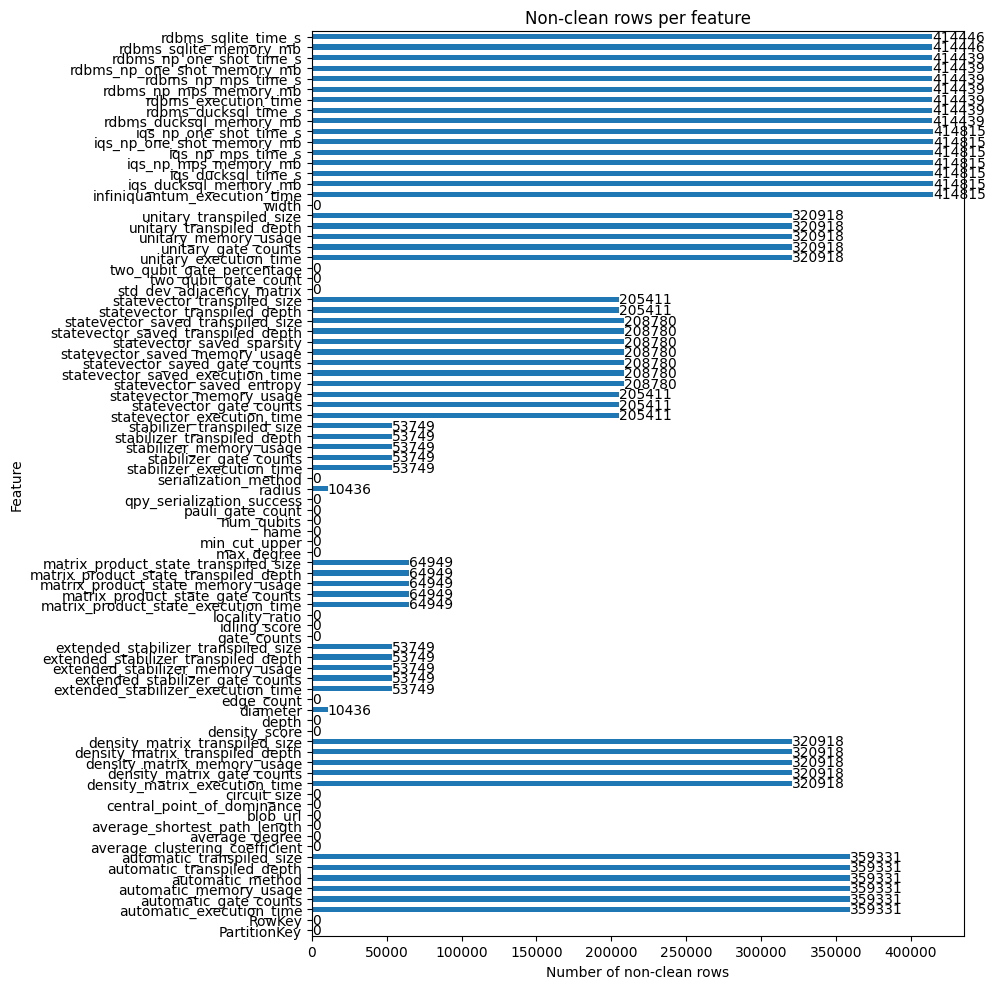

In [4]:
# dirty_counts = data.isna().sum()
dirty_counts = (
    dataFEATURES.replace(r"^\s*$", pd.NA, regex=True)
        .isna()
        .sum()
)

import matplotlib.pyplot as plt

ax = dirty_counts.plot(kind="barh", figsize=(10, 10))

for i, v in enumerate(dirty_counts):
    ax.text(v, i, str(v), va="center", ha="left")

plt.xlabel("Number of non-clean rows")
plt.ylabel("Feature")
plt.title("Non-clean rows per feature")
plt.tight_layout()
plt.show()



In [5]:
dataDYNAMIC = dataFEATURES.dropna(subset=["statevector_saved_entropy", "statevector_saved_sparsity"])
print(len(dataDYNAMIC))

206040


In [6]:
dataGRAPH = dataFEATURES.dropna(subset=["radius", "diameter"])
print(len(dataGRAPH))

404384


In [7]:
dataCLEAN = dataDYNAMIC.dropna(subset=["radius", "diameter"])
print(len(dataCLEAN))

195932


In [8]:
PRIMARY_KEY = ["RowKey"]

This dataCLEAN is a table of all the raw data with correct features extracted, we still need to decompose into the schema tables
So The RDBMS and QISKIT Use case columns should be in their own table linked with the foreign key (or just copied with all features). 
The core circuit features table should be its own table.

In [9]:
dataCLEAN_FEATURES_INFERQ = dataCLEAN.copy(deep=True)

QISKIT_METHODS = [
    "statevector_saved",
    "statevector",
    "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    "unitary",
    "automatic"
]

RDBMS_METHOD_COLUMNS = [   
    # RDBMS COLUMNS
    'infiniquantum_execution_time',
    'iqs_ducksql_memory_mb',
    'iqs_ducksql_time_s',
    'iqs_np_mps_memory_mb',
    'iqs_np_mps_time_s',
    'iqs_np_one_shot_memory_mb',
    'iqs_np_one_shot_time_s',
    'rdbms_ducksql_memory_mb',
    'rdbms_ducksql_time_s',
    'rdbms_execution_time',
    'rdbms_np_mps_memory_mb',
    'rdbms_np_mps_time_s',
    'rdbms_np_one_shot_memory_mb',
    'rdbms_np_one_shot_time_s',
    'rdbms_sqlite_memory_mb',
    'rdbms_sqlite_time_s'
]

QISKIT_METHOD_COLUMNS = [
    f"{m}_{suffix}"
    for m in QISKIT_METHODS
    for suffix in (
        "transpiled_size",
        "transpiled_depth",
        "memory_usage",
        "execution_time",
        "gate_counts",
    )
] 

dataCLEAN_FEATURES = dataCLEAN_FEATURES_INFERQ.drop(columns=QISKIT_METHOD_COLUMNS + RDBMS_METHOD_COLUMNS)
print(len(dataCLEAN_FEATURES))
print(dataCLEAN_FEATURES.columns.tolist())

195932
['PartitionKey', 'RowKey', 'automatic_method', 'average_clustering_coefficient', 'average_degree', 'average_shortest_path_length', 'blob_url', 'central_point_of_dominance', 'circuit_size', 'density_score', 'depth', 'diameter', 'edge_count', 'gate_counts', 'idling_score', 'locality_ratio', 'max_degree', 'min_cut_upper', 'name', 'num_qubits', 'pauli_gate_count', 'qpy_serialization_success', 'radius', 'serialization_method', 'statevector_saved_entropy', 'statevector_saved_sparsity', 'std_dev_adjacency_matrix', 'two_qubit_gate_count', 'two_qubit_gate_percentage', 'width']


In [10]:
# data_QISKIT_USE_CASE = dataCLEAN[PRIMARY_KEY + QISKIT_METHOD_COLUMNS].copy(deep=True)
# data_RDBMS_USE_CASE = dataCLEAN[PRIMARY_KEY + RDBMS_METHOD_COLUMNS].copy(deep=True)


data_QISKIT_USE_CASE = (
    dataCLEAN[PRIMARY_KEY + QISKIT_METHOD_COLUMNS]
    .loc[~dataCLEAN[QISKIT_METHOD_COLUMNS].isna().all(axis=1)]
    .copy(deep=True)
)

data_RDBMS_USE_CASE = (
    dataCLEAN[PRIMARY_KEY + RDBMS_METHOD_COLUMNS]
    .loc[~dataCLEAN[RDBMS_METHOD_COLUMNS].isna().all(axis=1)]
    .copy(deep=True)
)

dataCLEAN_FEATURES.to_csv("data_clean_features.csv", index=False)
data_QISKIT_USE_CASE.to_csv("data_sim_qiskit.csv", index=False)
data_RDBMS_USE_CASE.to_csv("data_sim_rdbms.csv", index=False)

print("RDBMS rows : " + str(len(data_RDBMS_USE_CASE)))
print("Qiskit rows : " + str(len(data_QISKIT_USE_CASE)))

RDBMS rows : 333
Qiskit rows : 195932


Now that the individual clean tables are stored, we can look into how much data can be used for the use cases. Saving better tables if necessary.

In [11]:
print("At least 1 sim worked")
dataSIM_ONE_WORKED = data_QISKIT_USE_CASE.loc[
    data_QISKIT_USE_CASE[QISKIT_METHOD_COLUMNS].notna().any(axis=1)
].copy(deep=True)
print(len(dataSIM_ONE_WORKED))
dataSIM = data_QISKIT_USE_CASE.dropna(subset=QISKIT_METHOD_COLUMNS)
print("All sim worked: ")
print(len(dataSIM))
AUTO_COLS = [c for c in QISKIT_METHOD_COLUMNS if c.startswith("automatic_")]
dataSIM_AUTOMATIC_WORKED = data_QISKIT_USE_CASE.loc[
    data_QISKIT_USE_CASE[AUTO_COLS].notna().any(axis=1)
].copy(deep=True)
print("Auto worked")
print(len(dataSIM_AUTOMATIC_WORKED))


# SANITY CHECK
AUTO_COLS = [c for c in QISKIT_METHOD_COLUMNS if c.startswith("automatic_")]
OTHER_COLS = [c for c in QISKIT_METHOD_COLUMNS if not c.startswith("automatic_")]

num_only_auto = (
    data_QISKIT_USE_CASE[AUTO_COLS].notna().any(axis=1)
    & data_QISKIT_USE_CASE[OTHER_COLS].notna().any(axis=1).eq(False)
).sum()

print("Only automatic worked:", num_only_auto)


At least 1 sim worked
195932
All sim worked: 
15718
Auto worked
45376
Only automatic worked: 0


In [12]:
dataSIM.to_csv("data_clean_all_sim_qiskit.csv", index=False)
dataSIM_ONE_WORKED.to_csv("data_clean_sim_1_worked_qiskit.csv", index=False)
dataSIM_AUTOMATIC_WORKED.to_csv("data_clean_sim_auto_worked_qiskit.csv", index=False)

In [18]:
import pandas as pd

# Example column pattern: method + "_memory_usage"
memory_columns = [method + "_memory_usage" for method in QISKIT_METHODS]

# Filter rows where all memory usage columns are equal
rows_with_equal_memory = dataSIM_AUTOMATIC_WORKED[
    dataSIM_AUTOMATIC_WORKED[memory_columns].nunique(axis=1) == 1
]

# Number of such rows
num_rows_equal_memory = len(rows_with_equal_memory)
print(num_rows_equal_memory)


30761
